In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, SimpleRNN, GRU, LSTM, Dense, Flatten, GlobalMaxPool1D
from tensorflow.keras.models import Model 
from tensorflow.keras.optimizers import SGD, Adam

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [4]:
df.tail()

,date,open,high,low,close,volume,Name
1254,2018-02-01,56.280,56.42,55.89,56.00,14690146,SBUX
1255,2018-02-02,55.900,56.32,55.70,55.77,15358909,SBUX
1256,2018-02-05,55.530,56.26,54.57,54.69,16059955,SBUX
1257,2018-02-06,53.685,56.06,53.56,55.61,17415065,SBUX
1258,2018-02-07,55.080,55.43,54.44,54.46,13927022,SBUX


In [5]:
#Start by trying to predict the price itself.
series = df['close'].to_numpy().reshape(-1, 1)
series.shape

(1259, 1)

In [6]:
#Normalising data
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [7]:
#Building the dataset
T = 10
D = 1
X = []
Y = []
for t in range(len(series) -  T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)
    
X = np.array(X).reshape(-1, T, D)
Y = np.array(Y)
N = len(X)
print("X.shape = ", X.shape)

X.shape =  (1249, 10, 1)


In [8]:
#Trying autoregressive RNN with LSTM units.
i = Input(shape = (T, D))
x = LSTM(5)(i)
x = Dense(1)(x)

model = Model(i, x)
model.compile(
    loss = 'mse',
    optimizer = Adam(learning_rate = 0.1)
)

In [9]:
r = model.fit(
    X[:-N // 2], Y[:-N // 2],
    epochs = 80,
    validation_data = (X[-N // 2:], Y[-N // 2:])
)

Epoch 1/80
20/20 [==============================] - 5s 33ms/step - loss: 0.1599 - val_loss: 0.3558
Epoch 2/80
20/20 [==============================] - 0s 10ms/step - loss: 0.0131 - val_loss: 0.0523
Epoch 3/80
20/20 [==============================] - 0s 10ms/step - loss: 0.0070 - val_loss: 0.0422
Epoch 4/80
20/20 [==============================] - 0s 10ms/step - loss: 0.0065 - val_loss: 0.0381
Epoch 5/80
20/20 [==============================] - 0s 11ms/step - loss: 0.0080 - val_loss: 0.0325
Epoch 6/80
20/20 [==============================] - 0s 11ms/step - loss: 0.0063 - val_loss: 0.0351
Epoch 7/80
20/20 [==============================] - 0s 11ms/step - loss: 0.0055 - val_loss: 0.0279
Epoch 8/80
20/20 [==============================] - 0s 13ms/step - loss: 0.0053 - val_loss: 0.0265
Epoch 9/80
20/20 [==============================] - 0s 13ms/step - loss: 0.0053 - val_loss: 0.0238
Epoch 10/80
20/20 [==============================] - 0s 11ms/step - loss: 0.0053 - val_loss: 0.0267
Epoch 11/

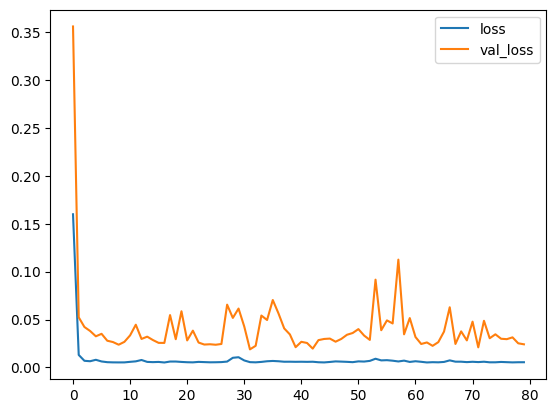

In [10]:
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show() 

40/40 [==============================] - 1s 2ms/step


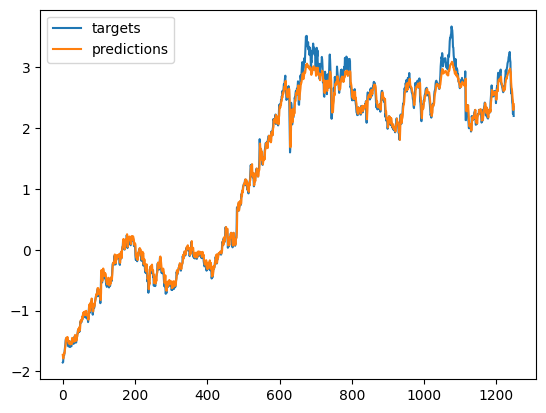

In [11]:
#One-Step forecast using true targets(wrong way to predict)
outputs = model.predict(X)
predictions = outputs[:, 0]
plt.plot(Y, label = 'targets')
plt.plot(predictions, label = 'predictions')
plt.legend()
plt.show()

1/1 [==============================] - 0s 21ms/step


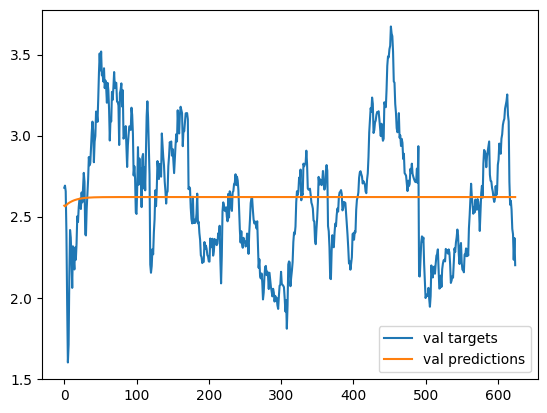

In [12]:
#Multi-step forecast using predictions(correct way to predict)
last_x = X[-N // 2]
val_targets = Y[-N // 2:]
val_predictions = []
while len(val_predictions) < len(val_targets):
    p = model.predict(last_x.reshape(1, T, D))[0, 0]
    val_predictions.append(p)
    last_x = np.roll(last_x, -1)
    last_x[-1] = p
    
plt.plot(val_targets, label = 'val targets')
plt.plot(val_predictions, label = 'val predictions')
plt.legend()
plt.show() 

Model does not perform well on multi-step forecast. In the single step forecast the model appears to perform well, but this is merely training to the noise and a misleading performance result, since singe-step forecast is wrong.

In [13]:
#Method 2: trying to predict returns = (final_price - initial_price) / initial_price
df['PrevClose'] = df['close'].shift(1)
df.head() 

,date,open,high,low,close,volume,Name,PrevClose
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915


In [14]:
df['Return'] = (df['close'] - df['PrevClose']) / df['PrevClose']
df.head()

,date,open,high,low,close,volume,Name,PrevClose,Return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


<AxesSubplot: >

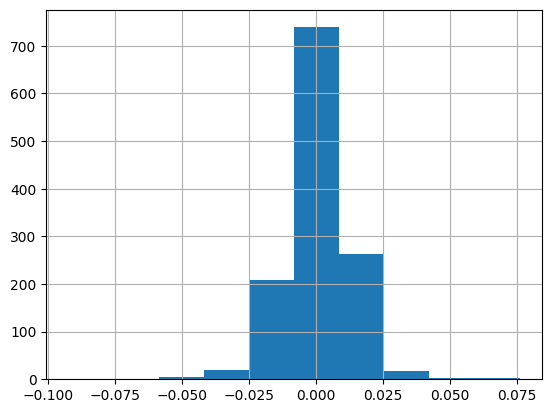

In [15]:
#small values, so may need normalising.
df['Return'].hist()

In [16]:
series = df['Return'].to_numpy()[1:].reshape(-1, 1)
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [17]:
#Building the dataset
T = 10
D = 1
X = []
Y = []
for t in range(len(series) -  T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)
    
X = np.array(X).reshape(-1, T, D)
Y = np.array(Y)
N = len(X)
print("X.shape = ", X.shape)

X.shape =  (1248, 10, 1)


In [18]:
#Trying autoregressive RNN with LSTM units.
i = Input(shape = (T, D))
x = LSTM(5)(i)
x = Dense(1)(x)

model = Model(i, x)
model.compile(
    loss = 'mse',
    optimizer = Adam(learning_rate = 0.01)
)

In [19]:
r = model.fit(
    X[:-N // 2], Y[:-N // 2],
    epochs = 80,
    validation_data = (X[-N // 2:], Y[-N // 2:])
)

Epoch 1/80
20/20 [==============================] - 2s 32ms/step - loss: 0.9921 - val_loss: 1.1417
Epoch 2/80
20/20 [==============================] - 0s 11ms/step - loss: 0.9866 - val_loss: 1.1352
Epoch 3/80
20/20 [==============================] - 0s 10ms/step - loss: 0.9844 - val_loss: 1.1399
Epoch 4/80
20/20 [==============================] - 0s 10ms/step - loss: 0.9861 - val_loss: 1.1397
Epoch 5/80
20/20 [==============================] - 0s 10ms/step - loss: 0.9832 - val_loss: 1.1450
Epoch 6/80
20/20 [==============================] - 0s 10ms/step - loss: 0.9828 - val_loss: 1.1421
Epoch 7/80
20/20 [==============================] - 0s 10ms/step - loss: 0.9829 - val_loss: 1.1446
Epoch 8/80
20/20 [==============================] - 0s 10ms/step - loss: 0.9851 - val_loss: 1.1338
Epoch 9/80
20/20 [==============================] - 0s 10ms/step - loss: 0.9872 - val_loss: 1.1396
Epoch 10/80
20/20 [==============================] - 0s 10ms/step - loss: 0.9838 - val_loss: 1.1433
Epoch 11/

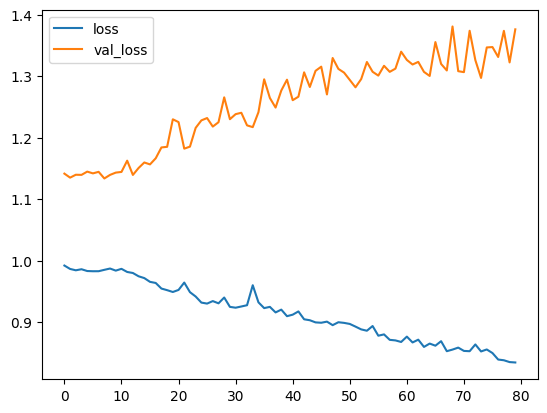

In [20]:
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show() 

Model has a hard time learning anything, since for the loss to go down, the validation loss keeps increasing, indicating that the model is
simply fitting to the noise.

In [44]:
#Method 3: Using all the data and simplifying to a classification problem.
input_data = df[['open', 'high', 'low','close', 'volume']].values
targets = df['Return'].values

In [45]:
#Building the dataset.
T = 10 #Try increasing later.
D = input_data.shape[1]
N = len(input_data) - T

In [46]:
#Normalize inputs
Ntrain = len(input_data) * 2 // 3 #using (2/3)rds of the input as training data.
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T])
input_data = scaler.transform(input_data)

In [47]:
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros((Ntrain))
for t in range(Ntrain):
    X_train[t, :, :] = input_data[t : T + t]
    Y_train[t] = (targets[T + t] > 0)
Y_train

array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1.,
       0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0.,
       1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1.,
       1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1.,
       1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0.,
       1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1.,
       1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0.,
       1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
       0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 0., 1., 1.

In [48]:
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros((N - Ntrain))
for u in range(N - Ntrain):
    t = u + Ntrain
    X_test[u, :, :] = input_data[t : T + t]
    Y_test[u] = (targets[T + t] > 0)

In [49]:
#Build RNN(binary classification output).
i = Input(shape = (T, D))
x = LSTM(50)(i)
x = Dense(1, activation = 'sigmoid')(x)

model = Model(i, x)

model.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(learning_rate = 0.001),
    metrics = ['accuracy']
)

In [50]:
r = model.fit(
    X_train, Y_train,
    batch_size = 32,
    epochs = 300,
    validation_data = (X_test, Y_test)
)

Epoch 1/300
27/27 [==============================] - 3s 28ms/step - loss: 0.6992 - accuracy: 0.4863 - val_loss: 0.6941 - val_accuracy: 0.4732
Epoch 2/300
27/27 [==============================] - 0s 10ms/step - loss: 0.6943 - accuracy: 0.4994 - val_loss: 0.6956 - val_accuracy: 0.4902
Epoch 3/300
27/27 [==============================] - 0s 10ms/step - loss: 0.6915 - accuracy: 0.5209 - val_loss: 0.6932 - val_accuracy: 0.4902
Epoch 4/300
27/27 [==============================] - 0s 9ms/step - loss: 0.6919 - accuracy: 0.5244 - val_loss: 0.6935 - val_accuracy: 0.4976
Epoch 5/300
27/27 [==============================] - 0s 9ms/step - loss: 0.6906 - accuracy: 0.5256 - val_loss: 0.6921 - val_accuracy: 0.5244
Epoch 6/300
27/27 [==============================] - 0s 9ms/step - loss: 0.6903 - accuracy: 0.5411 - val_loss: 0.6969 - val_accuracy: 0.4951
Epoch 7/300
27/27 [==============================] - 0s 9ms/step - loss: 0.6907 - accuracy: 0.5340 - val_loss: 0.6912 - val_accuracy: 0.5390
Epoch 8/30

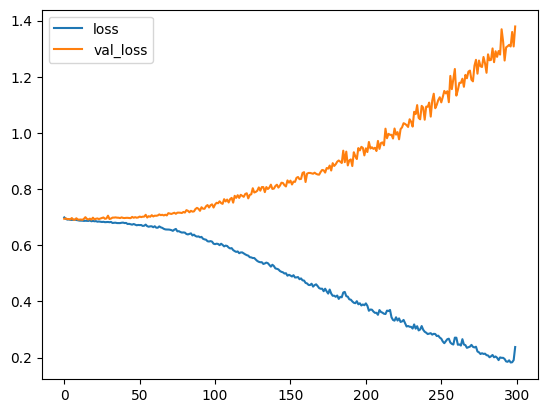

In [51]:
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

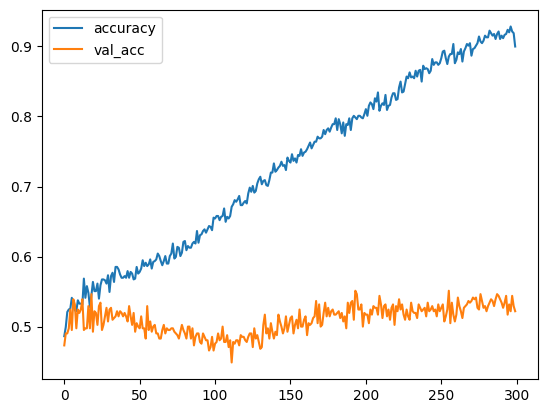

In [52]:
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_acc')
plt.legend()
plt.show()